<a href="https://colab.research.google.com/github/dipucriodigital/ciencia-de-dados-e-analytics/blob/main/machine-learning/ML_Aula3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning - Aluno: Maurício Lopes da Silva
## MVP - Sprint-04 : Qualidade de Software, Segurança e Sistemas Inteligentes

## Configuração do ambiente

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Carga do Dataset

O dataset contém diversas informações de um banco multinacional, com os dados dos seus correntistas, que possam prever a rotatividade dos seus clientes, e o objetivo é prever se o cliente saiu do banco durante algum período ou não.

Descrição das Colunas

- customer_id: Id do cliente (não utilizado).
- credit_score: Pontuação de crédito.
- country: País de residência.
- gender: Gênero.
- age: Idade.
- tenure: Há quantos anos tem conta bancária no banco.
- balance: Saldo da conta
- products_number: Quantidade de Produtos no banco.
- credit_card: igual a 1 tem cartão de crédito ou 0 se não.
- active_member: igual a 1 se cliente ativo ou 0 se não.
- estimated_salary: Salário estimado.
- churn: Campo alvo => igual a 1 se o cliente saiu do banco durante algum período ou 0 se não saiu.

In [ ]:
# Informa a URL de importação do dataset
url = "/content/Churn_Prediction_Classification.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Substituição do conteúdo das variáveis categóricas em informações numéricas
mapping_country ={
   'France'   : 1,
    'Spain'   : 2,
    'Germany' : 3
}
mapping_gender ={
    'Female'  : 1,
    'Male'    : 2
}
dataset["country"] = dataset["country"].map(mapping_country)
dataset["gender"]  = dataset["gender"].map(mapping_gender)

# Mostra as primeiras linhas do dataset
dataset.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,1,1,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,1,1,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,1,1,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  int64  
 3   gender            10000 non-null  int64  
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 937.6 KB


## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.30 # tamanho do conjunto de teste
seed      = 7    # semente aleatória

# Não considera o campo customer_id irrelevante para análise e a varável alvo que queremos prever
array = dataset.values
X     = array[:,1:-1]

# seleciona a variável alvo (variável que queremos prever)
y     = array[:,-1]

# Separação conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring       = 'accuracy'
num_particoes = 20
kfold         = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

LR: 0.790571 (0.009350)
KNN: 0.760000 (0.013522)
CART: 0.794143 (0.017273)
NB: 0.787714 (0.011990)
SVM: 0.796286 (0.001309)
Bagging: 0.859000 (0.016445)
RF: 0.858714 (0.015766)
ET: 0.854714 (0.016691)
Ada: 0.852000 (0.018219)
GB: 0.861857 (0.016017)
Voting: 0.800714 (0.006933)


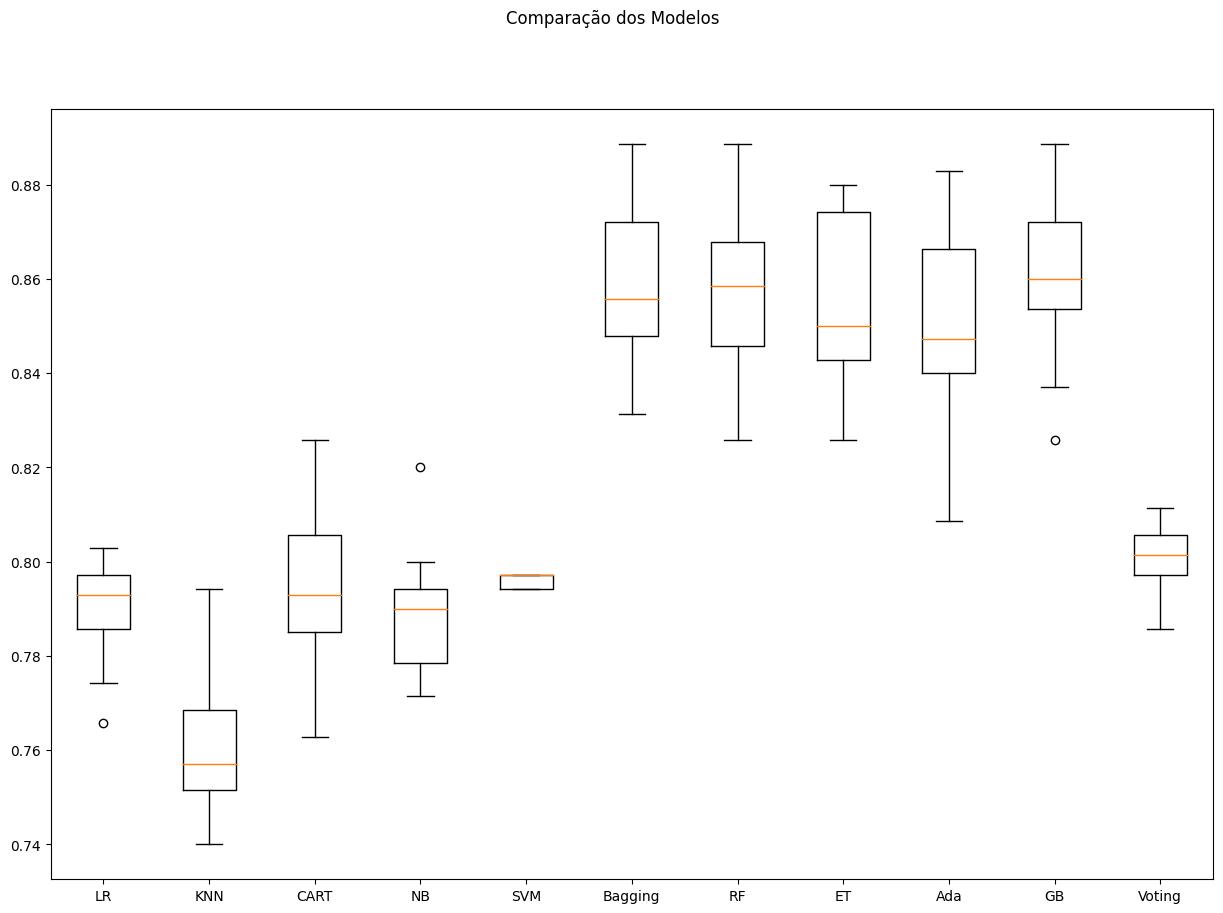

In [ ]:
# definindo uma semente global
np.random.seed(7)

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base         = DecisionTreeClassifier()
num_trees    = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases       = []
model1      = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2      = DecisionTreeClassifier()
bases.append(('cart', model2))
model3      = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names   = []

# Avaliação dos modelos (treinamento)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.791 (0.009)
KNN-orig: 0.760 (0.014)
CART-orig: 0.794 (0.017)
NB-orig: 0.788 (0.012)
SVM-orig: 0.796 (0.001)
Bag-orig: 0.859 (0.016)
RF-orig: 0.859 (0.016)
ET-orig: 0.855 (0.017)
Ada-orig: 0.852 (0.018)
GB-orig: 0.862 (0.016)
Vot-orig: 0.801 (0.007)
LR-padr: 0.810 (0.015)
KNN-padr: 0.830 (0.017)
CART-padr: 0.794 (0.020)
NB-padr: 0.828 (0.012)
SVM-padr: 0.853 (0.016)
Bag-padr: 0.856 (0.018)
RF-padr: 0.859 (0.017)
ET-padr: 0.857 (0.015)
Ada-padr: 0.852 (0.018)
GB-padr: 0.862 (0.017)
Vot-padr: 0.848 (0.014)
LR-norm: 0.811 (0.014)
KNN-norm: 0.815 (0.017)
CART-norm: 0.794 (0.020)
NB-norm: 0.828 (0.012)
SVM-norm: 0.844 (0.012)
Bag-norm: 0.859 (0.015)
RF-norm: 0.860 (0.017)
ET-norm: 0.857 (0.015)
Ada-norm: 0.852 (0.018)
GB-norm: 0.862 (0.016)
Vot-norm: 0.841 (0.012)


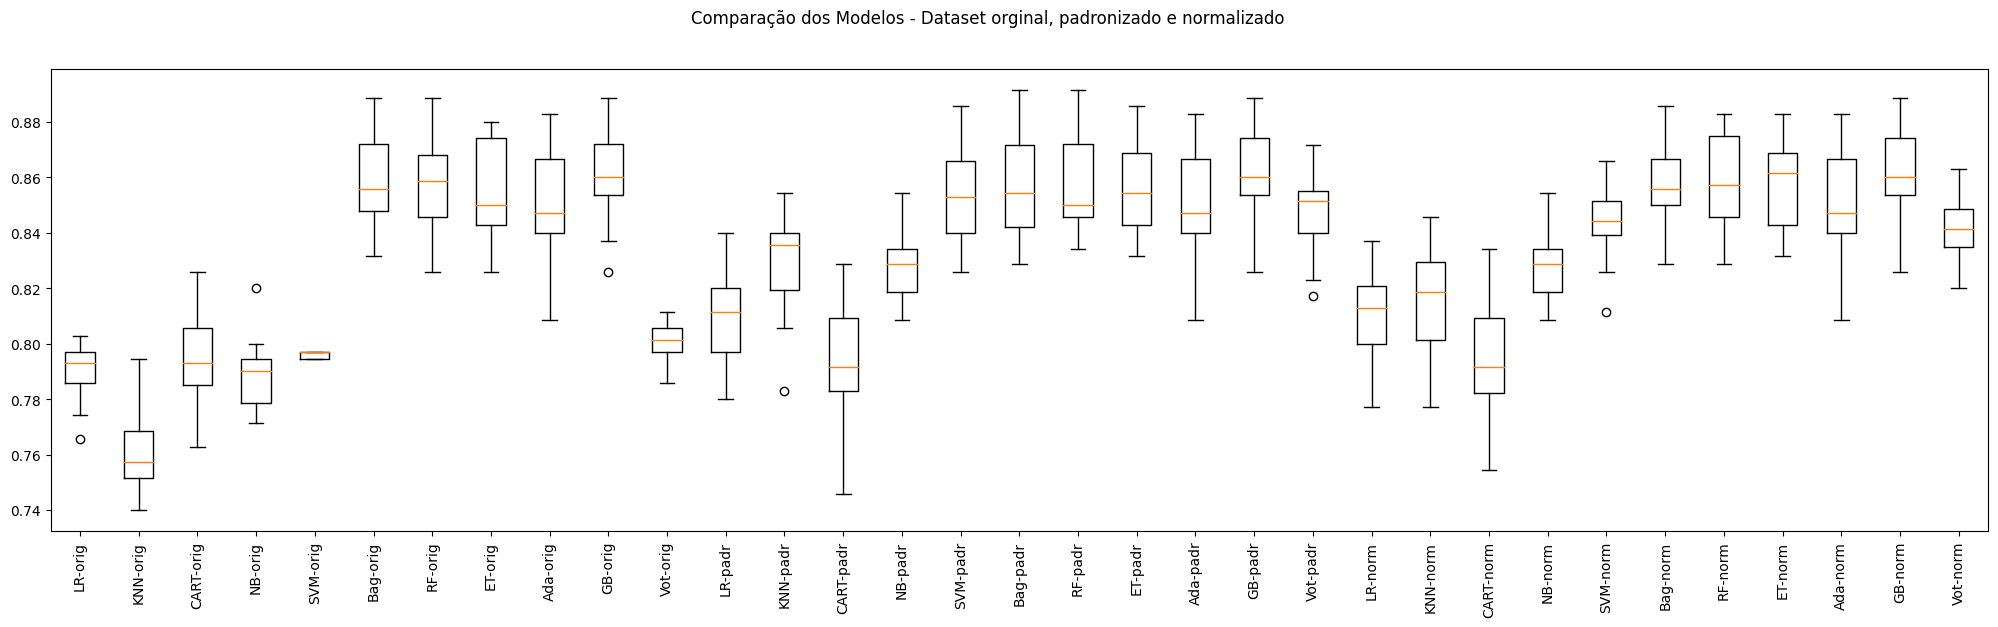

In [ ]:
# definindo uma semente global para este bloco
np.random.seed(7)

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results   = []
names     = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log           = ('LR', LogisticRegression(max_iter=200))
knn               = ('KNN', KNeighborsClassifier())
cart              = ('CART', DecisionTreeClassifier())
naive_bayes       = ('NB', GaussianNB())
svm               = ('SVM', SVC())
bagging           = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest     = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees       = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost          = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting            = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler   = ('StandardScaler', StandardScaler())
min_max_scaler    = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines
# A ordem de execução é da esquerda para a direita.

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax  = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros Grid Search

A otimização de hiperparâmetros é o processo de encontrar os valores ideais para os hiperparâmetros de um modelo de machine learning. O objetivo é encontrar a combinação de hiperparâmetros que resulta no melhor desempenho do modelo.


In [ ]:
# Definindo uma semente global para este bloco
np.random.seed(7)

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler  = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold   = 5

# Devido ao grande tempo de resposta para o resultado da validação será gerado umm arquivo de saida
# com as informações da melhor configuração do modelo.
f = open('saida_modelo.txt','at')

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, verbose=3, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    #print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))
    # Gravando no arquivo a melhor configuração
    saida = "Modelo: %s - Valor: %f usando %s" % (name, grid.best_score_, grid.best_params_)
    f.write(f'{saida}\n')

# Fecha arquivo de saido da melhor configuração do modelo
f.close()

In [ ]:
#########################################################################################
# Dataset Churn : Avalicação do melhor modelo
#########################################################################################
# Modelo: LR-orig       - Valor: 0.796286 usando {'LR__C': 0.01, 'LR__solver': 'saga'}
# Modelo: LR-padr       - Valor: 0.811429 usando {'LR__C': 0.1, 'LR__solver': 'liblinear'}
# Modelo: LR-norm       - Valor: 0.811143 usando {'LR__C': 10, 'LR__solver': 'saga'}
# Modelo: KNN-orig      - Valor: 0.792143 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 15}
# Modelo: KNN-padr      - Valor: 0.836571 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
# Modelo: KNN-norm      - Valor: 0.818286 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
# Modelo: CART-orig     - Valor: 0.838286 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 10}
# Modelo: CART-padr     - Valor: 0.838286 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 10}
# Modelo: CART-norm     - Valor: 0.837571 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 10}
# Modelo: NB-orig       - Valor: 0.796286 usando {'NB__var_smoothing': 1e-07}
# Modelo: NB-padr       - Valor: 0.828714 usando {'NB__var_smoothing': 1e-09}
# Modelo: NB-norm       - Valor: 0.828714 usando {'NB__var_smoothing': 1e-09}
# Modelo: SVM-orig      - Valor: 0.796286 usando {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
# Modelo: SVM-padr      - Valor: 0.854857 usando {'SVM__C': 100, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}
# Modelo: SVM-norm      - Valor: 0.856857 usando {'SVM__C': 100, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
# Modelo: Bagging-orig  - Valor: 0.856286 usando {}
# Modelo: Bagging-padr  - Valor: 0.853714 usando {}
# Modelo: Bagging-norm  - Valor: 0.856143 usando {}
# Modelo: RF-orig       - Valor: 0.864143 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 10, 'RF__n_estimators': 100}
# Modelo: RF-padr       - Valor: 0.863857 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 50}
# Modelo: RF-norm       - Valor: 0.864000 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 50}
# Modelo: ET-orig       - Valor: 0.860429 usando {'ET__max_depth': None, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 50}
# Modelo: ET-padr       - Valor: 0.860000 usando {'ET__max_depth': 30, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 100}
# Modelo: ET-norm       - Valor: 0.861286 usando {'ET__max_depth': None, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 50}
# Modelo: Ada-orig      - Valor: 0.857000 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 200}
# Modelo: Ada-padr      - Valor: 0.857000 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 200}
# Modelo: Ada-norm      - Valor: 0.857000 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 200}
# Modelo: GB-orig       - Valor: 0.864000 usando {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 200}
# Modelo: GB-padr       - Valor: 0.864143 usando {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 200}
# Modelo: GB-norm       - Valor: 0.864286 usando {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 200}
# Modelo: Voting-orig   - Valor: 0.800857 usando {}
# Modelo: Voting-padr   - Valor: 0.849286 usando {}
# Modelo: Voting-norm   - Valor: 0.837714 usando {}

## Finalização do Modelo

In [ ]:
############################################################################################################
# Avaliação do modelo com o conjunto de testes
#
# 1º Melhor modelo na avaliação       : GB-norm - Melhor: 0.864286 usando {'GB__learning_rate': 0.1,
#                                                                          'GB__max_depth': 3,
#                                                                          'GB__n_estimators': 200}
#
# 2º Modelo utilizado teste de unidade: KNN-padr usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
#
############################################################################################################

# Definindo semente global do bloco
np.random.seed(7)

# Ajuste do scaler com o conjunto de treino
scaler    = MinMaxScaler().fit(X_train)

# aplicação da normalização no conjunto de treino
rescaledX = scaler.transform(X_train)

########################################################################
# Preparação do modelo 1º Melhor modelo : GB-norm ( Gradient Boosting )
########################################################################

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3 )
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste do Melhor modelo : GB-norm
rescaledTestX = scaler.transform(X_test) # aplicação da normalização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(f"1º Melhor modelo : GB-norm - Melhor: {accuracy_score(y_test, predictions)}")

########################################################################
# Preparação do modelo utilizado teste de unidade : KNN-padr
########################################################################

model = KNeighborsClassifier(metric='euclidean', n_neighbors=9)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste 2º Melhor modelo : RF-orig
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(f"Modelo utilizado teste de unidade : KNN-padr : {accuracy_score(y_test, predictions)}")


1º Melhor modelo : GB-norm - Melhor: 0.8663333333333333
Modelo utilizado teste de unidade : KNN-padr : 0.8153333333333334


Rodando o melhor modelo da avaliação (GradientBoostingClassifier) a partir de um pipeline com os hiperparâmetros otimizados.

In [ ]:
# Define semente global do bloco
np.random.seed(7)

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3 )

# Prepara pipeline do melhor modelo
pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('GB', model)])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print(accuracy_score(y_test, predictions))

0.8663333333333333


## Salvando os arquivos do melhor modelo avaliado (GradientBoostingClassifier)

In [ ]:
# Salvando o modelo
model_filename = 'gb_Churn_Classifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'minmax_scaler_Churn.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Salvando o pipeline
pipeline_filename = 'gb_Churn_pipeline.pkl'
with open(pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[1:-1]) # desconsidera campo customer_id do dataframe
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("X_test_dataset_Churn.csv", index=False)
y_test_df.to_csv("y_test_dataset_Churn.csv", index=False)

## Simulando a aplicação do melhor modelo avaliado em dados não vistos

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da normalização com TODO o dataset
model.fit(rescaledX, y)

GradientBoostingClassifier(n_estimators=200)

In [ ]:
# Novos dados - não sabemos a classe!
data = {'credit_score':  [619, 608],
        'country': [1, 2],
        'gender': [1, 1],
        'age': [42, 41],
        'tenure': [2, 1],
        'balance': [0.0, 8380786.0],
        'products_number': [1, 1],
        'credit_card': [1, 0],
        'active_member': [1, 1],
        'estimated_salary': [101348.00, 112542.58],
        }

atributos = ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:10].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 0.538       0.          0.          0.32432432  0.2         0.
   0.          1.          1.          0.50673049]
 [ 0.516       0.5         0.          0.31081081  0.1        33.40314787
   0.          0.          1.          0.56270874]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1.]


## Salvando arquivo pipeline do modelo escolhido para realização do teste de unidade (KNN)

In [ ]:
# Define semente global do bloco
np.random.seed(7)

# Define modelo
model = KNeighborsClassifier(metric='euclidean', n_neighbors=9)

# Prepara pipeline do melhor modelo
pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('KNN', model)])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print(accuracy_score(y_test, predictions))

# Salvando o pipeline
pipeline_filename = 'knn_Churn_pipeline.pkl'
with open(pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

0.8153333333333334
